##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image Classification using tf.keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c03_exercise_flowers_with_data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c03_exercise_flowers_with_data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this Colab you will classify images of flowers. You will build an image classifier using `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`.


# Importing Packages

Let's start by importing required packages. **os** package is used to read files and directory structure, **numpy** is used to convert python list to numpy array and to perform required matrix operations and **matplotlib.pyplot** is used to plot the graph and display images in our training and validation data.

In [1]:
import os
import numpy as np
import glob
import shutil

import tensorflow as tf

import matplotlib.pyplot as plt

### TODO: Import TensorFlow and Keras Layers

In the cell below, import Tensorflow as `tf` and the Keras layers and models you will use to build your CNN. Also, import the `ImageDataGenerator` from Keras so that you can perform image augmentation.

In [2]:
#import packages
#Tensorflow libs
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Data Loading

In [5]:
import pathlib
#Declare url
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#Create a file and download it with Keras utils
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
# get dataset path
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 1s 0us/step


 random rose image

In [6]:
#get image count
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Total Images:",image_count)


Total Images: 3670


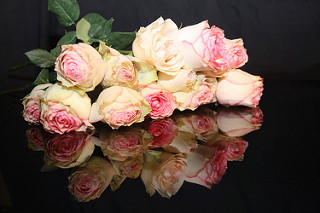

In [9]:
#get all images in rose file
roses = list(data_dir.glob('roses/*'))
# show third image
PIL.Image.open(str(roses[10]))

random tulips image

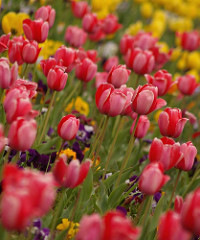

In [10]:
#get all images in tulips file
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[3]))

We will use tf.keras.utils.image_dataset_from_directory this utils for loading datset from directory. As you know, we have just downloaded the dataset to its own directory.

Okay, define the some parameter for loader

In [11]:
# Batch size
batch_size = 32
# image height
img_height = 180
# image width
img_width = 180

Use 80% of the images for training and 20% for validation.

We will create two separate sets for Train and Validation.

For train:

In [13]:
# split dataset for train
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


For Validation:

In [14]:
# split dataset for validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


If we want to see class tunes. We will see them in alphabetical order

In [15]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


After performing the dataset separation operations, now we can visualize and take part in our dataset.

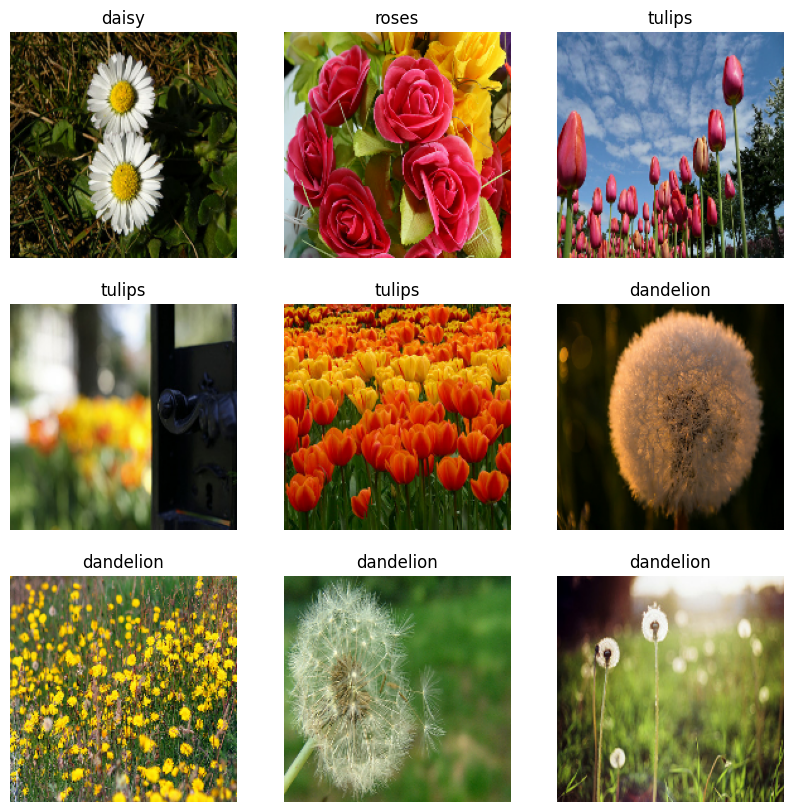

In [16]:
# determine figure size as 10 by 10
plt.figure(figsize=(10, 10))
# take image from train_ds
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # plot image using imshow
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

now check the images shapes

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

this part is important, now there are two different ways to ensure all images are buffered before model training; so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.

"Dataset.prefetch" is a method in TensorFlow, a popular machine learning library, that allows for efficient data loading during training. When using the prefetch method, the data is loaded from storage into memory in advance of when it will be needed, so that it is ready for use when the training algorithm requests it. This can help to reduce the amount of time spent waiting for data to be loaded during training and can therefore improve overall training performance.

In [18]:
#Create autotune object
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the image:

RGB channel values are in the range of [0, 255]. This is not ideal for a neural network and can be tiring, in general you should try to make your input values quite small so that it is easy to handle for a neural network.
based on this we will standardize the values to be in the range [0, 1] using tf.keras.layers:

In [19]:
# Create a normalization layer
normalization_layer = layers.Rescaling(1./255)

In [20]:
#normalize dataser using with norm. layer
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# sparete as image and label
image_batch, labels_batch = next(iter(normalized_ds))
# check the first image max and min value
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print("minumum value:",np.min(first_image), "maximum values: ",np.max(first_image))

minumum value: 0.0 maximum values:  1.0


For convenience, let us set up the path for the training and validation sets

# Data Augmentation

Overfitting generally occurs when we have small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In **tf.keras** we can implement this using the same **ImageDataGenerator** class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

## Experiment with Various Image Transformations

In this section you will get some practice doing some basic image transformations. Before we begin making transformations let's define our `batch_size` and our image size. Remember that the input to our CNN are images of the same size. We therefore have to resize the images in our dataset to the same size.

### TODO: Set Batch and Image Size

In the cell below, create a `batch_size` of 100 images and set a value to `IMG_SHAPE` such that our training data consists of images with width of 150 pixels and height of 150 pixels.

In [ ]:
batch_size =
IMG_SHAPE =

### TODO: Apply Random Horizontal Flip

In the cell below, use ImageDataGenerator to create a transformation that rescales the images by 255 and then applies a random horizontal flip. Then use the `.flow_from_directory` method to apply the above transformation to the images in our training set. Make sure you indicate the batch size, the path to the directory of the training images, the target size for the images, and to shuffle the images.

In [ ]:
image_gen =

train_data_gen =

Let's take 1 sample image from our training examples and repeat it 5 times so that the augmentation can be applied to the same image 5 times over randomly, to see the augmentation in action.

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### TODO: Apply Random Rotation

In the cell below, use ImageDataGenerator to create a transformation that rescales the images by 255 and then applies a random 45 degree rotation. Then use the `.flow_from_directory` method to apply the above transformation to the images in our training set. Make sure you indicate the batch size, the path to the directory of the training images, the target size for the images, and to shuffle the images.

In [ ]:
image_gen =

train_data_gen =

Let's take 1 sample image from our training examples and repeat it 5 times so that the augmentation can be applied to the same image 5 times over randomly, to see the augmentation in action.

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### TODO: Apply Random Zoom

In the cell below, use ImageDataGenerator to create a transformation that rescales the images by 255 and then applies a random zoom of up to 50%. Then use the `.flow_from_directory` method to apply the above transformation to the images in our training set. Make sure you indicate the batch size, the path to the directory of the training images, the target size for the images, and to shuffle the images.

In [ ]:
image_gen =

train_data_gen =

Let's take 1 sample image from our training examples and repeat it 5 times so that the augmentation can be applied to the same image 5 times over randomly, to see the augmentation in action.

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### TODO: Put It All Together

In the cell below, use ImageDataGenerator to create a transformation that rescales the images by 255 and that applies:

- random 45 degree rotation
- random zoom of up to 50%
- random horizontal flip
- width shift of 0.15
- height shift of 0.15

Then use the `.flow_from_directory` method to apply the above transformation to the images in our training set. Make sure you indicate the batch size, the path to the directory of the training images, the target size for the images, to shuffle the images, and to set the class mode to `sparse`.

In [ ]:
image_gen_train =


train_data_gen =

Let's visualize how a single image would look like 5 different times, when we pass these augmentations randomly to our dataset.

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### TODO: Create a Data Generator for the Validation Set

Generally, we only apply data augmentation to our training examples. So, in the cell below, use ImageDataGenerator to create a transformation that only rescales the images by 255. Then use the `.flow_from_directory` method to apply the above transformation to the images in our validation set. Make sure you indicate the batch size, the path to the directory of the validation images, the target size for the images, and to set the class mode to `sparse`. Remember that it is not necessary to shuffle the images in the validation set.

In [ ]:
image_gen_val =
val_data_gen =

# TODO: Create the CNN

In the cell below, create a convolutional neural network that consists of 3 convolution blocks. Each convolutional block contains a `Conv2D` layer followed by a max pool layer. The first convolutional block should have 16 filters, the second one should have 32 filters, and the third one should have 64 filters. All convolutional filters should be 3 x 3. All max pool layers should have a `pool_size` of `(2, 2)`.

After the 3 convolutional blocks you should have a flatten layer followed by a fully connected layer with 512 units. The CNN should output class probabilities based on 5 classes which is done by the **softmax** activation function. All other layers should use a **relu** activation function. You should also add Dropout layers with a probability of 20%, where appropriate.

In [ ]:
model =

# TODO: Compile the Model

In the cell below, compile your model using the ADAM optimizer, the sparse cross entropy function as a loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so make sure you also pass the metrics argument.

In [ ]:
# Compile the model

# TODO: Train the Model

In the cell below, train your model using the **fit_generator** function instead of the usual **fit** function. We have to use the `fit_generator` function because we are using the **ImageDataGenerator** class to generate batches of training and validation data for our model. Train the model for 80 epochs and make sure you use the proper parameters in the `fit_generator` function.

In [ ]:
epochs =

history =

# TODO: Plot Training and Validation Graphs.

In the cell below, plot the training and validation accuracy/loss graphs.

In [ ]:
acc =
val_acc =

loss =
val_loss =

epochs_range =


# TODO: Experiment with Different Parameters

So far you've created a CNN with 3 convolutional layers and followed by a fully connected layer with 512 units. In the cells below create a new CNN with a different architecture. Feel free to experiment by changing as many parameters as you like. For example, you can add more convolutional layers, or more fully connected layers. You can also experiment with different filter sizes in your convolutional layers, different number of units in your fully connected layers, different dropout rates, etc... You can also experiment by performing image augmentation with more image transformations that we have seen so far. Take a look at the [ImageDataGenerator Documentation](https://keras.io/preprocessing/image/) to see a full list of all the available image transformations. For example, you can add shear transformations, or you can vary the brightness of the images, etc... Experiment as much as you can and compare the accuracy of your various models. Which parameters give you the best result?